# Simulation of CO + * => CO*

In [75]:
import cantera as ct
import rmgpy.chemkin
import subprocess
import datetime
import numpy as np
import matplotlib.pyplot as plt
import yaml
import os

import sys
sys.path.append('/home/moon/kmc/zacros/Zacros-Wrapper')

import zacros_wrapper as zw


%matplotlib inline

In [77]:
# convert RMG mech to yaml
cur_dir = '/home/moon/rmg/rmg2kmc/examples/co_adsorbs_pt111'
gas_mech_file = os.path.join(cur_dir, 'chem_annotated-gas.inp')
surface_mech_file = os.path.join(cur_dir, 'chem_annotated-surface.inp')
transport = os.path.join(cur_dir, 'tran.dat')


gas_sp, gas_rxns = rmgpy.chemkin.load_chemkin_file(gas_mech_file)


subprocess.run(['ck2yaml', f'--input={gas_mech_file}', f'--surface={surface_mech_file}', f'--transport={transport}'])


Wrote YAML mechanism file to '/home/moon/rmg/rmg2kmc/examples/co_adsorbs_pt111/chem_annotated-gas.yaml'.
Mechanism contains 2 species and 1 reactions.
Validating mechanism...
PASSED


CompletedProcess(args=['ck2yaml', '--input=/home/moon/rmg/rmg2kmc/examples/co_adsorbs_pt111/chem_annotated-gas.inp', '--surface=/home/moon/rmg/rmg2kmc/examples/co_adsorbs_pt111/chem_annotated-surface.inp', '--transport=/home/moon/rmg/rmg2kmc/examples/co_adsorbs_pt111/tran.dat'], returncode=0)

In [73]:
# Load the mechanism

model_file = os.path.join(cur_dir, 'chem_annotated-gas.yaml')
gas = ct.Solution(model_file, "gas")
surf = ct.Interface(model_file, "surface1", [gas])


print('Gas Phase Species:')
for sp in gas.species():
    print(sp.name)
print()
    
print('Gas Phase Reactions:')
for rxn in gas.reactions():
    print(rxn)    
print()

print('Surface Phase Species:')
for sp in surf.species():
    print(sp.name)
print()

print('Surface Phase Reactions:')
for rxn in surf.reactions():
    print(rxn)

Gas Phase Species:
Ar
CO(2)

Gas Phase Reactions:

Surface Phase Species:
X(4)
CO_X(8)

Surface Phase Reactions:
CO(2) + X(4) => CO_X(8)


In [87]:
# Create a simulation file for both Cantera and Zacros to use

ct_mol_fracs = {'Ar': 0.99, 'CO(2)': 0.01}

rmg_labels = [s.label for s in gas_sp]
rmg_mol_fracs = {}
for key in ct_mol_fracs.keys():
    new_key = rmg_labels[gas.species_names.index(key)]
    rmg_mol_fracs[new_key] = ct_mol_fracs[key]


simulation_settings = {
    'T_K': 1000,
    'P_Pa': 101325,
    'starting_gas_mol_frac_ct': ct_mol_fracs,
    'starting_gas_mol_frac_rmg': rmg_mol_fracs
#     'starting_gas_mol_frac': {'Ar': 0.9, 'CO(2)': 0.1},
}

simulation_settings_file = os.path.join(cur_dir, 'reactor_settings.yaml')
with open(simulation_settings_file, 'w') as f:
    f.write(f'# Simulation file generated {datetime.datetime.now()}\n\n')
    yaml.dump(simulation_settings, f)

In [88]:
surf.site_density

2.7200000000000002e-08

In [96]:
# Set Reactor conditions:
# initialize T and P
T = simulation_settings['T_K'] #  K
P = simulation_settings['P_Pa']  # Pa
X = simulation_settings['starting_gas_mol_frac_ct']
V = 1.0 #  TODO units


In [103]:
# Run the reactor

gas.TPX = T, P, X
surf.TP = T, P

# # These settings need to match zacros
# volume_flow = 1.0

# # Catalyst settings (really need to double check these)
catalyst_weight = 4.24e-3
cat_site_per_wt = 5*61.67*1e-6*1e3 # [mol/kg] 1e-6mol/micromole, 1000g/kg
site_density = (
    surf.site_density * 1000
)  # [mol/m^2]cantera uses kmol/m^2, convert to mol/m^2
cat_area = (catalyst_weight * cat_site_per_wt) / site_density  # [m^3]
surf.coverages = "X(4):1.0"


gas_reactor = ct.IdealGasReactor(gas)
gas_reactor.volume = V
# TODO sort out catalyst area
surface_reactor = ct.ReactorSurface(surf, gas_reactor, A=cat_area)

# set up mass flow controllers
inlet = ct.Reservoir(gas)
exhaust = ct.Reservoir(gas)


MAX_STEPS = 100000
# delta_t = 1e-2
delta_t = 1.0 / (surf.forward_rate_constants[0])
# delta_t = 1e-9
t = np.arange(0, MAX_STEPS * delta_t, delta_t)

CO_cov = np.zeros(MAX_STEPS)
X_cov = np.zeros(MAX_STEPS)

for i in range(MAX_STEPS):
    X_cov[i] = surf.coverages[surf.species_names.index('X(4)')]
    CO_cov[i] = surf.coverages[surf.species_names.index('CO_X(8)')]
    
    surf.advance_coverages(delta_t)


## User must run rmg2kmc and then zacros, but we could use subprocess to do it here

In [98]:
# Run RMG2KMC
os.chdir(cur_dir)
subprocess.run([
    'python',
    '../../rmg2kmc.py',
    'chem_annotated-gas.inp',
    'chem_annotated-surface.inp',
    'species_dictionary.txt'
])


Using Chemkin Reader


CompletedProcess(args=['python', '../../rmg2kmc.py', 'chem_annotated-gas.inp', 'chem_annotated-surface.inp', 'species_dictionary.txt'], returncode=0)

In [99]:
# Run zacros
os.chdir(os.path.join(cur_dir, 'zacros'))
subprocess.run(['./zacros.x'])

 NO THREADS


CompletedProcess(args=['./zacros.x'], returncode=0)

In [100]:
# Run KMC results
kmc_dir = '/home/moon/rmg/rmg2kmc/examples/co_adsorbs_pt111/zacros'

''' Read simulation results '''
my_trajectory = zw.kmc_traj()                           # Create single trajectory object
my_trajectory.Path = kmc_dir                            # Set directory for files
my_trajectory.ReadAllOutput(build_lattice=True)         # Read input and output files

''' Plot data '''
my_trajectory.PlotSurfSpecVsTime(save_data=True)                      # Plot surface species populations versus time
my_trajectory.PlotGasSpecVsTime()                       # Plot gas species populations versus time
my_trajectory.PlotElemStepFreqs(time_norm = True)       # Plot elementary step frequencies
#my_trajectory.PlotLattice()                             # Plot the lattice
#my_trajectory.LatticeMovie()                            # Plot the lattice snapshots
np.save(os.path.join(kmc_dir, 'times.npy'), my_trajectory.specnumout.t)
np.save(os.path.join(kmc_dir, 'spec.npy'), my_trajectory.specnumout.spec)

CO_X


In [101]:
t_kmc = np.load(os.path.join(kmc_dir, 'times.npy'))
spec_kmc = np.load(os.path.join(kmc_dir, 'spec.npy'))

Text(0, 0.5, 'coverage fraction $\\theta$')

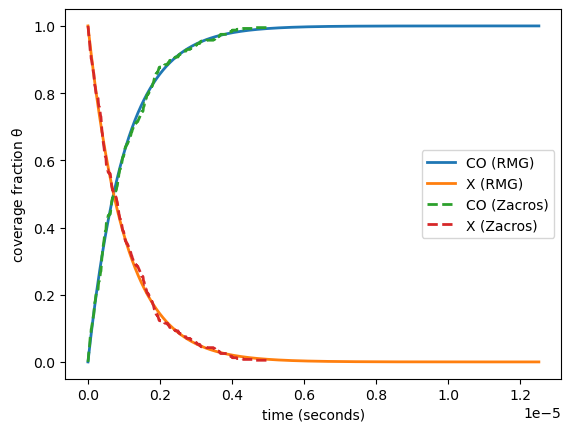

In [104]:
plt.plot(t, CO_cov)
plt.plot(t, X_cov)

plt.plot(t_kmc, spec_kmc[:, 1] / 400, linestyle='dashed')
plt.plot(t_kmc, 1.0 - spec_kmc[:, 1] / 400, linestyle='dashed')

plt.legend(['CO (RMG)', 'X (RMG)', 'CO (Zacros)', 'X (Zacros)'])
# plt.legend([])
# plt.xlim([0, 10])
plt.xlabel('time (seconds)')
plt.ylabel(r'coverage fraction $\theta$')




In [24]:
surf.reactions()[0].rate_coeff_units

<Units(m^3 / kmol / s) at 7fcb66f3c7b0>

In [25]:
# convert to zacros units
surf.forward_rate_constants[0] / ct.gas_constant / T * 1e5

96109764.88791367